In [2]:
!pip install wordcloud

    100% |████████████████████████████████| 163kB 4.0MB/s ta 0:00:01


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import re

# text preprocessing
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, TweetTokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

# deep learning model
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from keras.layers import Embedding, Input, Dense, LSTM, GlobalMaxPooling1D, GRU, Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import to_categorical

# regularizers
from keras.regularizers import L1L2, l2
# Wordcloud
from wordcloud import WordCloud

for dirname, _, filenames in os.walk('./'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./sentiment-analysis-with-lstm.ipynb
./novoLSTM.ipynb
./sentiment-cnnDeep.ipynb
./sentiment-analysis-with-lstm-cnn.ipynb
./README.md
./LSTM-sentiment.ipynb
./Tweets.csv
./.ipynb_checkpoints/sentiment-analysis-with-lstm-checkpoint.ipynb
./.ipynb_checkpoints/novoLSTM-checkpoint.ipynb
./.ipynb_checkpoints/sentiment-cnnDeep-checkpoint.ipynb
./.ipynb_checkpoints/LSTM-sentiment-checkpoint.ipynb
./.ipynb_checkpoints/sentiment-analysis-with-lstm-cnn-checkpoint.ipynb
./.git/ORIG_HEAD
./.git/config
./.git/HEAD
./.git/description
./.git/index
./.git/COMMIT_EDITMSG
./.git/FETCH_HEAD
./.git/objects/61/270eedf45b7ed1eb9f956d33acf7f12ad179ce
./.git/objects/a5/6bf23552ffdb577cf0138dcc9e91b833cd528d
./.git/objects/7d/c7736846f631c9aa1fb156754d784d03082abf
./.git/objects/10/4af8bdf40021c26ace58ac0fed8a1ee2ca77bb
./.git/objects/3a/b9a9886f5f05e777bc55072aab51096f501a7c
./.git/objects/06/c35a112bd38e7e3606aab8456f47ddb7eea36f
./.git/objects/f8/3577836b94b1f961eccc6f90c4c1b6d5c5a904
./.git/objects/2c/d31c4

In [6]:
df = pd.read_csv("./Tweets.csv")

In [7]:
df.shape

(14640, 15)

In [8]:
df.describe()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.464000e+04,14640.000000,10522.000000,14640.000000
mean,5.692184e+17,0.900169,0.638298,0.082650
std,7.791112e+14,0.162830,0.330440,0.745778
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.685592e+17,0.692300,0.360600,0.000000
50%,5.694779e+17,1.000000,0.670600,0.000000
75%,5.698905e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [10]:
df.sample(5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
10673,568994696980238336,negative,1.0000,Customer Service Issue,1.0000,US Airways,NaN,WesKnuckle,NaN,0,@USAirways @stephenrodrick Your team needs to ...,NaN,2015-02-20 20:44:41 -0800,"Boston, MA",Eastern Time (US & Canada)
5136,569314535103983617,negative,1.0000,Lost Luggage,0.6771,Southwest,NaN,scoobydoo9749,NaN,0,@SouthwestAir 9 hours at this airport and you ...,NaN,2015-02-21 17:55:37 -0800,"Tallahassee, FL",America/Chicago
7333,569666838340210689,negative,1.0000,Lost Luggage,1.0000,Delta,NaN,TomNaro,NaN,0,@JetBlue hey JetBlue. Still waiting to hear w...,NaN,2015-02-22 17:15:32 -0800,NaN,NaN
8859,567795026307325952,positive,1.0000,NaN,NaN,Delta,NaN,SOBtweets,NaN,0,@JetBlue thanks for the upgrade😉!! so far so g...,NaN,2015-02-17 13:17:38 -0800,NaN,NaN
13480,569852250488573952,negative,0.6831,Can't Tell,0.3873,American,NaN,ra1der7581,NaN,0,@AmericanAir 2days 2plains 2fails,NaN,2015-02-23 05:32:18 -0800,"Albuquerque,New Mexico",America/Boise


In [11]:
df[["text", "airline_sentiment"]]

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative
...,...,...
14635,@AmericanAir thank you we got on a different f...,positive
14636,@AmericanAir leaving over 20 minutes Late Flig...,negative
14637,@AmericanAir Please bring American Airlines to...,neutral
14638,"@AmericanAir you have my money, you change my ...",negative


In [12]:
def remove_stopwords(text):
    "removes stopwords"
    # customize stopwords
    my_stopwords = stopwords.words("english")
    my_stopwords.remove("not")
    # remove stopwords
    filtered_words = [word for word in text if word not in my_stopwords]
    return filtered_words

def remove_punctuation(text):
    "removes punctutation"
    my_punct = string.punctuation
    my_punct += "“”’" # add unusual apostrophes
    no_punct = [w for w in text if w not in my_punct]
    return no_punct

def remove_numbers(text):
    "removes strings containing only digits"
    reduced = re.sub(r'\b[0-9]+\b\s*', '', text)
    return reduced

def remove_signs(text, sign):
    "removes a particular sign"
    try:
        reduced = [w for w in text if sign not in w]
        return reduced
    except Exception as e:
        print(e)
        return text
    
def remove_links(text):
    "removes links"
    reduced = re.sub(r'http\S+', '', text)
    return reduced

In [13]:
def clean_text(inp_text):
    """
        This function is a pipeline for text preprocessing
        It consists of following steps:
            - converting text to lowercase
            - removing words containing only digits
            - removing links
            - removing stopwords
            - removing punctuation
            - removing mentions and hashtags
    """
    #lowercase
    text = inp_text.lower()
    # remove only number words
    text = remove_numbers(text)
    # remove links 
    text = remove_links(text)
    # divide input sentence into words
    tknzr = TweetTokenizer()
    text = tknzr.tokenize(text)
    # remove stopwords
    text = remove_stopwords(text)
    # remove punctuation
    text = remove_punctuation(text)
    # remove mentions
    text = remove_signs(text, "@")
    # remove hashtags
    text = remove_signs(text, "#")
    # join a list of words into a sentence
    filtered_sentence = (" ").join(text)
    return filtered_sentence

In [15]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vagner.antonio.silva/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [16]:
df["filtered_tweets"] = df["text"].apply(clean_text)

In [17]:
neg = " ".join(tweet for tweet in df[df["airline_sentiment"]=="negative"]["filtered_tweets"])
neu = " ".join(tweet for tweet in df[df["airline_sentiment"]=="neutral"]["filtered_tweets"])
pos = " ".join(tweet for tweet in df[df["airline_sentiment"]=="positive"]["filtered_tweets"])

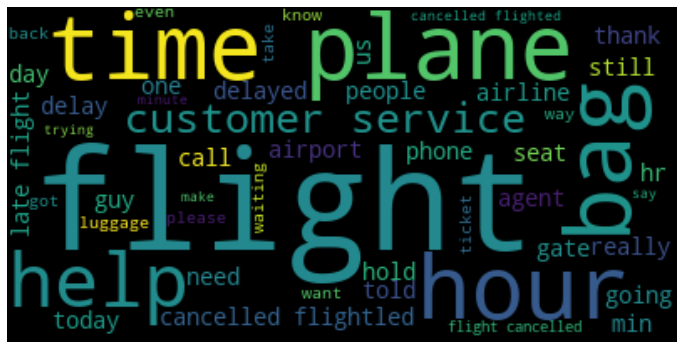

In [18]:
plt.figure(figsize=(12, 9))
neg_cloud = WordCloud(max_words=50).generate(neg)
plt.imshow(neg_cloud, interpolation='bilinear')
plt.axis("off");

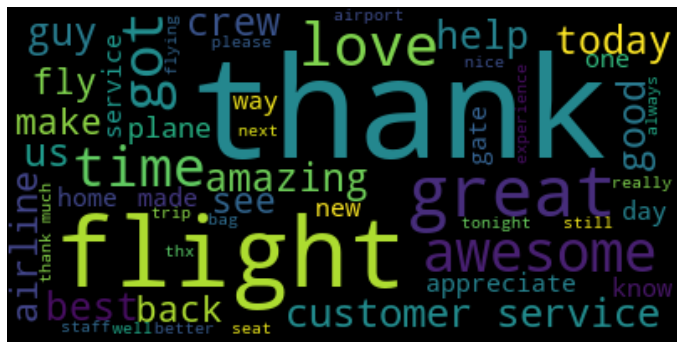

In [19]:
plt.figure(figsize=(12, 9))
pos_cloud = WordCloud(max_words=50).generate(pos)
plt.imshow(pos_cloud, interpolation='bilinear')
plt.axis("off");

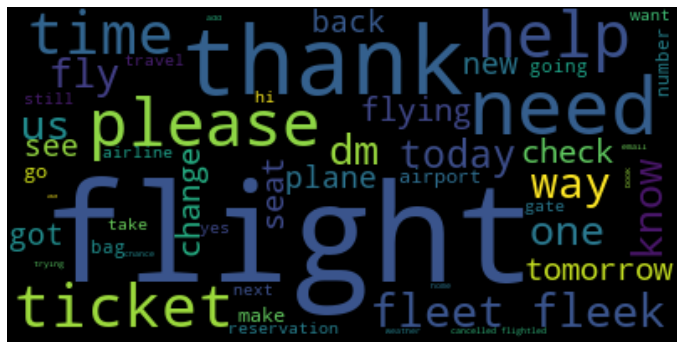

In [20]:
plt.figure(figsize=(12, 9))
neu_cloud = WordCloud(max_words=50).generate(neu)
plt.imshow(neu_cloud, interpolation='bilinear')
plt.axis("off");

In [21]:
def get_labels(sentiment):
    if sentiment == "negative":
        return 0
    if sentiment == "neutral":
        return 1
    if sentiment == "positive":
        return 2
    
df["label"] = df["airline_sentiment"].apply(get_labels)

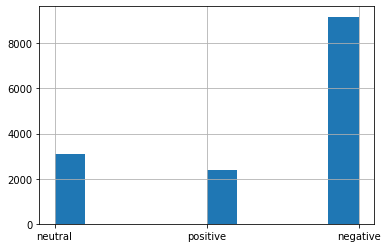

In [22]:
df["airline_sentiment"].hist();

In [23]:
# labels distribution
df["label"].value_counts() / df["label"].value_counts().sum()

0    0.626913
1    0.211680
2    0.161407
Name: label, dtype: float64

In [24]:
train_txt, test_txt, train_labels, test_labels = train_test_split(
    df["filtered_tweets"], df["label"], 
    test_size=0.2, stratify=df["label"], random_state=42)

In [25]:
train_labels.value_counts() / train_labels.value_counts().sum()

0    0.626878
1    0.211663
2    0.161458
Name: label, dtype: float64

In [26]:
tknz = Tokenizer()
tknz.fit_on_texts(train_txt)
train_sentences = tknz.texts_to_sequences(train_txt)
test_sentences = tknz.texts_to_sequences(test_txt)

In [27]:
vocab_size = len(tknz.word_counts)
vocab_size

9696

In [28]:
# add padding to the train set
train_pad = pad_sequences(train_sentences)

# max length of words in a single sentence
max_len = train_pad.shape[1]

# add padding to the test set using max len
test_pad = pad_sequences(test_sentences, maxlen=max_len)

In [29]:
train_pad.shape, test_pad.shape

((11712, 27), (2928, 27))

In [30]:
y_train = to_categorical(train_labels)
y_test = to_categorical(test_labels)
y_train[:4]

array([[0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.]], dtype=float32)

In [31]:
# size of the Embeddings vector
D = 15
# size of the hidden vector
M = 10
# vocab size
V = vocab_size
# sequence length
T = max_len

batch_size = 32

i = Input(shape=(T,))
x = Embedding(V+1, D)(i)
x = LSTM(M)(x)
x = Dense(3, activation='softmax')(x)

mbasic = Model(i, x)
# model.summary()

mbasic.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

basic = mbasic.fit(train_pad, y_train, batch_size=batch_size, epochs=10, validation_data=(test_pad, y_test))

Epoch 1/10
366/366 [==============================] - 4s 10ms/step - loss: 0.7854 - accuracy: 0.6625 - val_loss: 0.6560 - val_accuracy: 0.7404
Epoch 2/10
366/366 [==============================] - 3s 9ms/step - loss: 0.5454 - accuracy: 0.7834 - val_loss: 0.5811 - val_accuracy: 0.7753
Epoch 3/10
366/366 [==============================] - 3s 9ms/step - loss: 0.4153 - accuracy: 0.8443 - val_loss: 0.5809 - val_accuracy: 0.7824
Epoch 4/10
366/366 [==============================] - 3s 8ms/step - loss: 0.3175 - accuracy: 0.8860 - val_loss: 0.6067 - val_accuracy: 0.7790
Epoch 5/10
366/366 [==============================] - 3s 9ms/step - loss: 0.2489 - accuracy: 0.9160 - val_loss: 0.6535 - val_accuracy: 0.7749
Epoch 6/10
366/366 [==============================] - 3s 9ms/step - loss: 0.2036 - accuracy: 0.9301 - val_loss: 0.7241 - val_accuracy: 0.7719
Epoch 7/10
366/366 [==============================] - 3s 8ms/step - loss: 0.1689 - accuracy: 0.9438 - val_loss: 0.7567 - val_accuracy: 0.7688
Epoch

In [32]:
# size of the Embeddings vector
D = 15
# size of the hidden vector
M = 64
# vocab size
V = vocab_size
# sequence length
T = max_len

batch_size = 32

i = Input(shape=(T,))
x = Embedding(V+1, D)(i)
x = LSTM(M)(x)
x = Dense(3, activation='softmax')(x)

mbig = Model(i, x)
# model.summary()

mbig.compile(optimizer=Adam(lr=0.0003), loss='categorical_crossentropy', metrics=['accuracy'])

big = mbig.fit(train_pad, y_train, batch_size=batch_size, epochs=10, validation_data=(test_pad, y_test))

Epoch 1/10
366/366 [==============================] - 4s 11ms/step - loss: 0.8572 - accuracy: 0.6276 - val_loss: 0.7437 - val_accuracy: 0.6479
Epoch 2/10
366/366 [==============================] - 4s 10ms/step - loss: 0.6643 - accuracy: 0.7037 - val_loss: 0.6526 - val_accuracy: 0.7531
Epoch 3/10
366/366 [==============================] - 4s 11ms/step - loss: 0.5549 - accuracy: 0.7693 - val_loss: 0.6183 - val_accuracy: 0.7613
Epoch 4/10
366/366 [==============================] - 4s 11ms/step - loss: 0.4815 - accuracy: 0.8047 - val_loss: 0.6112 - val_accuracy: 0.7671
Epoch 5/10
366/366 [==============================] - 4s 11ms/step - loss: 0.4225 - accuracy: 0.8358 - val_loss: 0.6355 - val_accuracy: 0.7620
Epoch 6/10
366/366 [==============================] - 4s 10ms/step - loss: 0.3814 - accuracy: 0.8525 - val_loss: 0.6540 - val_accuracy: 0.7606
Epoch 7/10
366/366 [==============================] - 4s 10ms/step - loss: 0.3443 - accuracy: 0.8685 - val_loss: 0.7168 - val_accuracy: 0.7572

In [33]:
# size of the Embeddings vector
D = 10
# size of the hidden vector
M = 10
# vocab size
V = vocab_size
# sequence length
T = max_len

batch_size = 32

i = Input(shape=(T,))
x = Embedding(V+1, D)(i)
x = LSTM(M, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(3, activation='softmax')(x)

pool = Model(i, x)
# model.summary()

pool.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

lstm_pool = pool.fit(train_pad, y_train, batch_size=batch_size, epochs=10, validation_data=(test_pad, y_test))

Epoch 1/10
366/366 [==============================] - 3s 9ms/step - loss: 0.9219 - accuracy: 0.6222 - val_loss: 0.8401 - val_accuracy: 0.6270
Epoch 2/10
366/366 [==============================] - 3s 8ms/step - loss: 0.7051 - accuracy: 0.6738 - val_loss: 0.6500 - val_accuracy: 0.7421
Epoch 3/10
366/366 [==============================] - 3s 8ms/step - loss: 0.5171 - accuracy: 0.8155 - val_loss: 0.5898 - val_accuracy: 0.7736
Epoch 4/10
366/366 [==============================] - 3s 9ms/step - loss: 0.4022 - accuracy: 0.8659 - val_loss: 0.5724 - val_accuracy: 0.7739
Epoch 5/10
366/366 [==============================] - 3s 8ms/step - loss: 0.3255 - accuracy: 0.8946 - val_loss: 0.5849 - val_accuracy: 0.7756
Epoch 6/10
366/366 [==============================] - 3s 8ms/step - loss: 0.2711 - accuracy: 0.9137 - val_loss: 0.6032 - val_accuracy: 0.7684
Epoch 7/10
366/366 [==============================] - 3s 8ms/step - loss: 0.2336 - accuracy: 0.9249 - val_loss: 0.6359 - val_accuracy: 0.7616
Epoch 

In [34]:
# size of the Embeddings vector
D = 15
# size of the hidden vector
M = 10
# vocab size
V = vocab_size
# sequence length
T = max_len

batch_size = 32

i = Input(shape=(T,))
x = Embedding(V+1, D)(i)
x = LSTM(M, recurrent_dropout=0.2)(x)
x = Dense(3, activation='softmax')(x)

rec_drop = Model(i, x)
# model.summary()

rec_drop.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

rd = rec_drop.fit(train_pad, y_train, batch_size=batch_size, epochs=10, validation_data=(test_pad, y_test))

Epoch 1/10
366/366 [==============================] - 6s 16ms/step - loss: 0.7829 - accuracy: 0.6795 - val_loss: 0.6308 - val_accuracy: 0.7695
Epoch 2/10
366/366 [==============================] - 5s 14ms/step - loss: 0.5077 - accuracy: 0.8072 - val_loss: 0.5458 - val_accuracy: 0.7889
Epoch 3/10
366/366 [==============================] - 5s 14ms/step - loss: 0.3721 - accuracy: 0.8612 - val_loss: 0.5737 - val_accuracy: 0.7794
Epoch 4/10
366/366 [==============================] - 6s 16ms/step - loss: 0.2876 - accuracy: 0.8975 - val_loss: 0.6010 - val_accuracy: 0.7865
Epoch 5/10
366/366 [==============================] - 6s 16ms/step - loss: 0.2311 - accuracy: 0.9198 - val_loss: 0.6693 - val_accuracy: 0.7736
Epoch 6/10
366/366 [==============================] - 6s 15ms/step - loss: 0.1918 - accuracy: 0.9355 - val_loss: 0.7343 - val_accuracy: 0.7650
Epoch 7/10
366/366 [==============================] - 5s 14ms/step - loss: 0.1671 - accuracy: 0.9436 - val_loss: 0.7814 - val_accuracy: 0.7756

In [35]:
import keras.backend as K
from keras.layers import Lambda
# size of the Embeddings vector
D = 15
# size of the hidden vector
M = 10
# vocab size
V = vocab_size
# sequence length
T = max_len

batch_size = 32

i = Input(shape=(T,))
mask = Lambda(lambda inputs: K.not_equal(inputs, 0))(i)
x = Embedding(V+1, D)(i)
x = LSTM(M, return_sequences=True)(x, mask=mask)
x = LSTM(M)(x, mask=mask)
# x = GlobalMaxPooling1D()(x)
x = Dense(3, activation='softmax')(x)

mmask = Model(i, x)
# model.summary()

mmask.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

mask = mmask.fit(train_pad, y_train, batch_size=batch_size, epochs=10, validation_data=(test_pad, y_test))

Epoch 1/10
366/366 [==============================] - 11s 31ms/step - loss: 0.7592 - accuracy: 0.6772 - val_loss: 0.6541 - val_accuracy: 0.7377
Epoch 2/10
366/366 [==============================] - 9s 25ms/step - loss: 0.5467 - accuracy: 0.7754 - val_loss: 0.6191 - val_accuracy: 0.7596
Epoch 3/10
366/366 [==============================] - 9s 26ms/step - loss: 0.4192 - accuracy: 0.8462 - val_loss: 0.6144 - val_accuracy: 0.7637
Epoch 4/10
366/366 [==============================] - 9s 25ms/step - loss: 0.3186 - accuracy: 0.8904 - val_loss: 0.6686 - val_accuracy: 0.7657
Epoch 5/10
366/366 [==============================] - 9s 25ms/step - loss: 0.2515 - accuracy: 0.9161 - val_loss: 0.7003 - val_accuracy: 0.7568
Epoch 6/10
366/366 [==============================] - 9s 25ms/step - loss: 0.2065 - accuracy: 0.9331 - val_loss: 0.7679 - val_accuracy: 0.7667
Epoch 7/10
366/366 [==============================] - 9s 25ms/step - loss: 0.1784 - accuracy: 0.9430 - val_loss: 0.7890 - val_accuracy: 0.753

In [36]:
# size of the Embeddings vector
D = 15
# size of the hidden vector
M = 10
# vocab size
V = vocab_size
# sequence length
T = max_len

batch_size = 64

i = Input(shape=(T,))
x = Embedding(V+1, D)(i)
x = GRU(M, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(3, activation='softmax')(x)

mgru = Model(i, x)
# model.summary()

mgru.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

gru = mgru.fit(train_pad, y_train, epochs=10, batch_size=batch_size, validation_data=(test_pad, y_test))

Epoch 1/10
183/183 [==============================] - 3s 16ms/step - loss: 0.9080 - accuracy: 0.6194 - val_loss: 0.7578 - val_accuracy: 0.6581
Epoch 2/10
183/183 [==============================] - 2s 12ms/step - loss: 0.6481 - accuracy: 0.7259 - val_loss: 0.6342 - val_accuracy: 0.7582
Epoch 3/10
183/183 [==============================] - 2s 10ms/step - loss: 0.5147 - accuracy: 0.8116 - val_loss: 0.6044 - val_accuracy: 0.7763
Epoch 4/10
183/183 [==============================] - 2s 11ms/step - loss: 0.4317 - accuracy: 0.8448 - val_loss: 0.6095 - val_accuracy: 0.7753
Epoch 5/10
183/183 [==============================] - 2s 10ms/step - loss: 0.3716 - accuracy: 0.8647 - val_loss: 0.6280 - val_accuracy: 0.7657
Epoch 6/10
183/183 [==============================] - 2s 10ms/step - loss: 0.3246 - accuracy: 0.8866 - val_loss: 0.6662 - val_accuracy: 0.7613
Epoch 7/10
183/183 [==============================] - 2s 11ms/step - loss: 0.2887 - accuracy: 0.9012 - val_loss: 0.7009 - val_accuracy: 0.7551

In [37]:
from keras.layers import BatchNormalization, Conv1D, Flatten
# size of the Embeddings vector
D = 15
# size of the hidden vector
M = 10
# vocab size
V = vocab_size
# sequence length
T = max_len

batch_size = 64

i = Input(shape=(T,))
x = Embedding(V+1, D)(i)
x = Conv1D(32, kernel_size=5)(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
# x = Conv1D(32, kernel_size=3)(x)
# x = Dropout(0.2)(x)
# x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(3, activation='softmax')(x)

mcnn = Model(i, x)
# model.summary()

mcnn.compile(optimizer=Adam(lr=0.0003), loss='categorical_crossentropy', metrics=['accuracy'])

cnn = mcnn.fit(train_pad, y_train, batch_size=batch_size, epochs=10, validation_data=(test_pad, y_test))

Epoch 1/10
183/183 [==============================] - 1s 6ms/step - loss: 0.8970 - accuracy: 0.6135 - val_loss: 1.0170 - val_accuracy: 0.6277
Epoch 2/10
183/183 [==============================] - 1s 5ms/step - loss: 0.6828 - accuracy: 0.7188 - val_loss: 0.8591 - val_accuracy: 0.6940
Epoch 3/10
183/183 [==============================] - 1s 4ms/step - loss: 0.5093 - accuracy: 0.7987 - val_loss: 0.6634 - val_accuracy: 0.7558
Epoch 4/10
183/183 [==============================] - 1s 4ms/step - loss: 0.3805 - accuracy: 0.8596 - val_loss: 0.6091 - val_accuracy: 0.7555
Epoch 5/10
183/183 [==============================] - 1s 4ms/step - loss: 0.2864 - accuracy: 0.8992 - val_loss: 0.6553 - val_accuracy: 0.7568
Epoch 6/10
183/183 [==============================] - 1s 4ms/step - loss: 0.2143 - accuracy: 0.9295 - val_loss: 0.7155 - val_accuracy: 0.7565
Epoch 7/10
183/183 [==============================] - 1s 4ms/step - loss: 0.1633 - accuracy: 0.9469 - val_loss: 0.7734 - val_accuracy: 0.7568
Epoch 

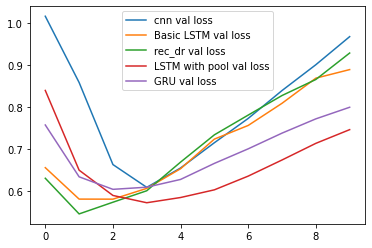

In [38]:
plt.plot(cnn.history['val_loss'], label="cnn val loss")
plt.plot(basic.history['val_loss'], label="Basic LSTM val loss")
plt.plot(rd.history['val_loss'], label="rec_dr val loss")
plt.plot(lstm_pool.history['val_loss'], label="LSTM with pool val loss")
plt.plot(gru.history['val_loss'], label="GRU val loss")
plt.legend();

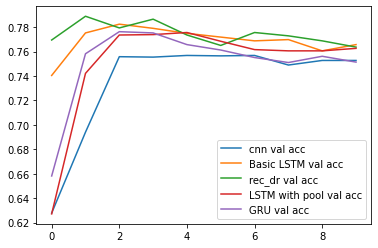

In [39]:
plt.plot(cnn.history['val_accuracy'], label="cnn val acc")
plt.plot(basic.history['val_accuracy'], label="Basic LSTM val acc")
plt.plot(rd.history['val_accuracy'], label="rec_dr val acc")
plt.plot(lstm_pool.history['val_accuracy'], label="LSTM with pool val acc")
plt.plot(gru.history['val_accuracy'], label="GRU val acc")
plt.legend();

In [40]:
from sklearn.metrics import confusion_matrix

pred = rec_drop.predict(test_pad)

In [41]:
y_classes = pred.argmax(axis=-1)
y_classes

array([1, 0, 0, ..., 0, 0, 0])

In [42]:
test_labels.values

array([1, 2, 0, ..., 0, 0, 0])

In [43]:
confusion_matrix(y_classes, test_labels)

array([[1581,  225,   89],
       [ 193,  348,   76],
       [  62,   47,  307]])